# Load the functions (only do once)

In [1]:
using PETLION, Plots

┌ Info: Precompiling PETLION [5e0a28e4-193c-47fa-bbb8-9c901cc1ac2c]
└ @ Base loading.jl:1278


# Get the parameters file for an LCO/graphite cell
## For more info, look inside the file `params.jl`

In [21]:
p = Params(cathode=LCO, anode=LiC6,
    temperature = false, # true/false
    jacobian = :symbolic, # :symbolic/:AD
    solid_diffusion = :Fickian, # :Fickian or :quadratic/:polynomial approximation
    N_p = 10, # cathode discretization
    N_r_p = 10, # cathode particle discretization
    N_s = 10, # separator discretization
    N_n = 10, # anode discretization
    N_r_n = 10, # anode particle discretization
    );

Creating the functions for method I, param_no_funcs:
  Cathode: LCO, rxn_BV, & OCV_LCO
  Anode:   LiC6, rxn_BV, & OCV_LiC6
  System:  D_s_eff_isothermal, rxn_rate_isothermal, D_eff_linear, & K_eff
  --------
  Temperature:     false
  Solid diffusion: Fickian, finite_difference
  Aging:           false
  Edge values:     center
  Voltage bounds:  [2.5 V, 4.3 V]
  SOC bounds:      [0.0, 1.0]
  Anode sat. max:  0.99
  --------
  N.p:   10
  N.r_p: 10
  N.s:   10
  N.n:   10
  N.r_n: 10
Making initial guess function
Making symbolic model
Making symbolic Jacobian. May take a few mins
100.0%┣█████████████████████████████████████┫ 2139/2139 [01:33<00:00, 22.9 it/s]

Making initial condition functions
Finished

Continuing to create method V
Making initial guess function
Making symbolic model
Making symbolic Jacobian. May take a few mins
Making initial condition functions
Finished

Continuing to create method P
Making initial guess function
Making symbolic model
Making symbolic Jacobian. May t

# Running the model

## Inputs methods:

### 1. CC: Constant current
### 2. Cfunc: Variable current function (u, p, t)
### 3. CV: Constant voltage
### 4. CP: Constant power
### 5. Pfunc: Variable power function (u, p, t)

## All other possible inputs (SOC, outputs, etc.) are in `params.jl` under the `options_model` and `boundary_stop_conditions` headings

## Outputs:

### Y, YP, c_e, c_s_avg, T, film, Q, j, j_s, Φ_e, Φ_s, I, t, V, P, SOC

All options are defined the same as in LIONSIMBA

# 1. Fast charge

CC simulations do not requre an input time, but you can also run `model = run_model(p, 3600, CC=1, SOC=0)`.

Fast charge simulations can use a saturation limit with c_s_n_max that is on by default.


Run for I = 1.0C

PET.jl model
  --------
  Run:     I
  Time:    3072.9091 s
  Voltage: 4.0565 V
  Current: 1.0 C
  Power:   118.5718 W
  SOC:     0.8524
  Exit:    Above c_s_n saturation threshold



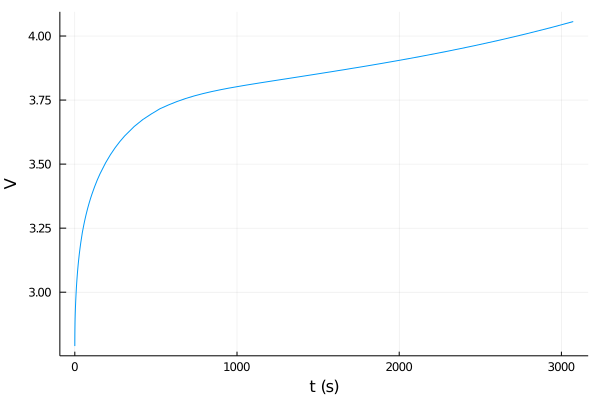

In [23]:
model = run_model(p, I=1, SOC=0, verbose=true)
plot(model, :V)

Note the exit reason above: "Above c_s_n saturation threshold"

Models can crash when fast charging too quickly if this is turned off. Use with caution.


Run for I = 1.0C

PET.jl model
  --------
  Run:     I
  Time:    3604.2418 s
  Voltage: 4.1652 V
  Current: 1.0 C
  Power:   121.7475 W
  SOC:     1.0
  Exit:    Above maximum SOC limit



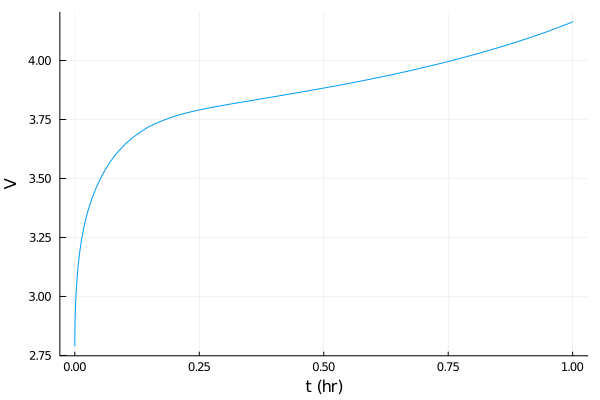

In [25]:
model = run_model(p, I=1, SOC=0, c_s_n_max=NaN, verbose=true)
plot(model, :V)

Now, the exit reason is "Above maximum SOC limit"

# 2. CC-CV

Setting up a 2C CC step into a CV hold at 4 V. First let's add `I` and `SOC` to the outputs (only save the outputs that you actually use).

If you want everything, you can use `outputs = :all`.

 In julia, `!` at the end of a function means it is modifying the first input, in this case, the model.

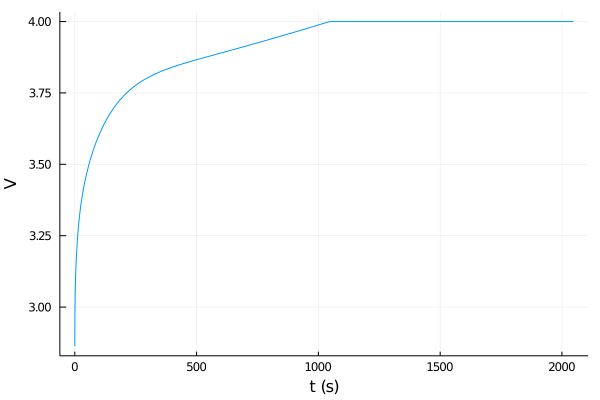

In [27]:
model = run_model(p, I=2, SOC=0, V_max=4, outputs=(:t, :V, :I, :SOC))
run_model!(model, p, 1000, V=:hold)
plot(model, :V)

## All the currents are in C-rates, not A/m^2 like LIONSIMBA

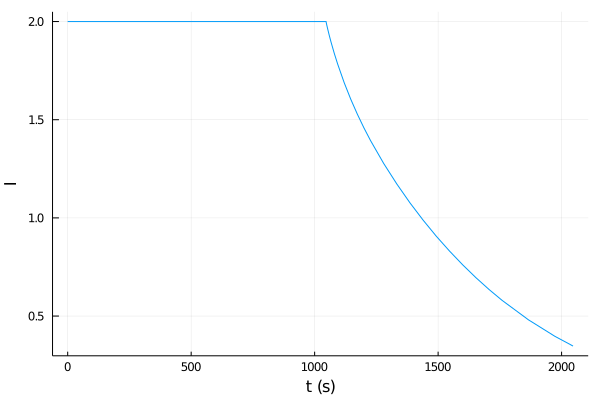

In [29]:
plot(model, :I)

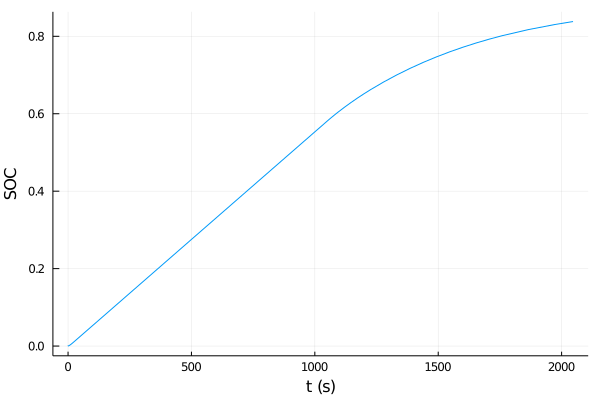

In [31]:
plot(model, :SOC)

# 3. Variable current functions

## If you want to use variable power, use `Pfunc` instead

In [33]:
function Cfunc(u, p, t) # u: vector of states, p: parameters, t: time
    cos(2π*t/500) # C-rate at time t. Starts at t=0
end

Cfunc (generic function with 1 method)

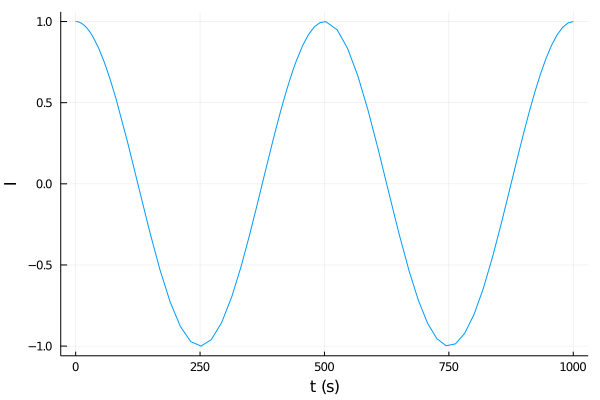

In [35]:
model = run_model(p, 1000, I=Cfunc, SOC=0.5, outputs=(:t, :I, :V, :c_e))
plot(model, :I)

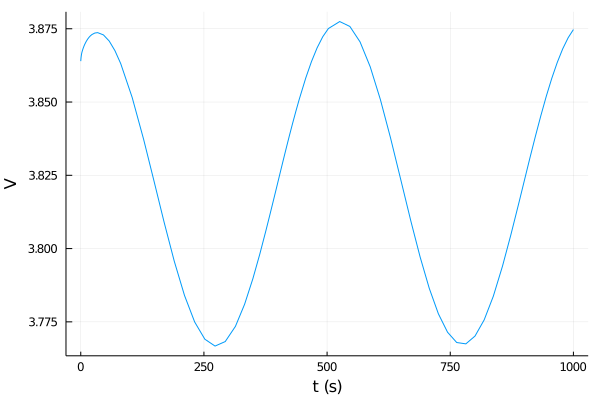

In [37]:
plot(model, :V)

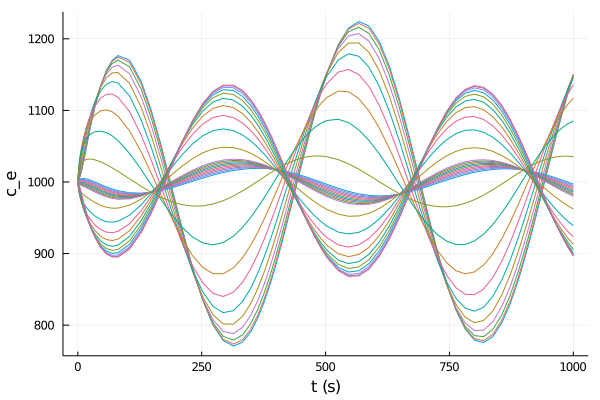

In [39]:
plot(model, :c_e)

# 4. GITT

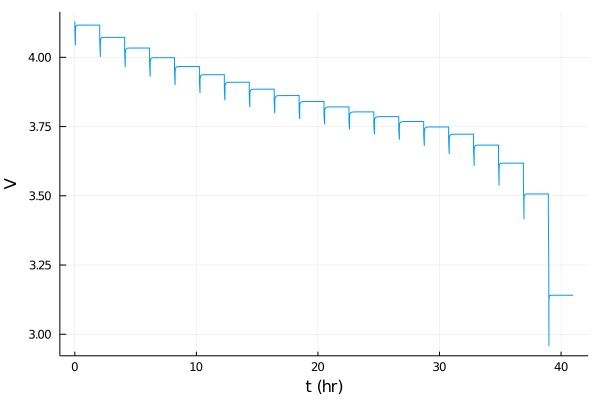

In [41]:
p.opts.SOC = 1
model = model_output()
for i in 1:20
    run_model!(model, p, 3600/20, I=-1, outputs = (:t, :V))
    run_model!(model, p, 2*3600, I=:rest)
end
plot(model, :V)

# 5. Power

In [43]:
model = run_model(p, 3000, P=100, SOC=0, outputs=(:t, :V, :P, :I))

PET.jl model
  --------
  Run:     P
  Time:    3000.0 s
  Voltage: 3.9853 V
  Current: 0.8584 C
  Power:   100.0 W
  SOC:     0.7509
  Exit:    Final time reached

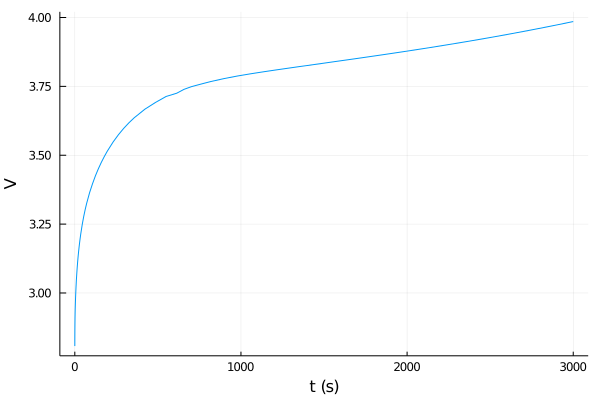

In [45]:
plot(model, :V)

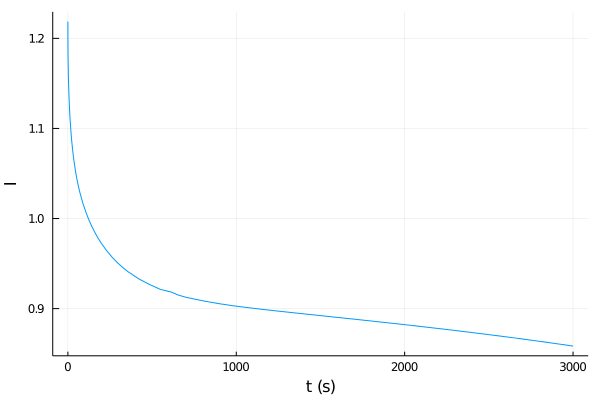

In [47]:
plot(model, :I)

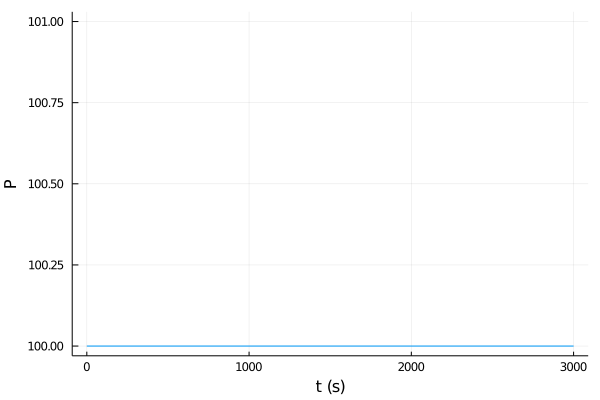

In [49]:
plot(model, :P)

# 6. Outputs

You can look at the outputs by using `model.output_name`, e.g., `model.t`, `model.V`, `model.I`, etc.

In [51]:
model.V

90-element Array{Float64,1}:
 2.8073166374399
 2.8088187488734384
 2.8100492293630914
 2.8124109767218917
 2.814675688917706
 2.818879727032019
 2.82277813502666
 2.8264104298633126
 2.833122892261062
 2.8390750609938626
 2.8492054748391293
 2.856432180660793
 2.8626815559228844
 ⋮
 3.863864651173962
 3.8695569175595637
 3.8753371695801775
 3.887219225755862
 3.8995330842694993
 3.9123185955763615
 3.925629891877194
 3.9395166113365088
 3.9540211178976135
 3.969173931660173
 3.984997280303717
 3.985325693006663

# 7. Degradation

In [53]:
p_aging = Params(cathode=LCO, anode=LiC6,
    aging = :SEI, # :SEI and :R_film
    temperature = false,
    )

param{jacobian_symbolic}:
  Cathode: LCO, rxn_BV, & OCV_LCO
  Anode:   LiC6, rxn_BV, & OCV_LiC6
  System:  D_s_eff_isothermal, rxn_rate_isothermal, D_eff_linear, & K_eff
  Methods: I, V, P
  --------
  Temperature:     false
  Solid diffusion: Fickian, finite_difference
  Aging:           SEI
  Edge values:     center
  Voltage bounds:  [2.5 V, 4.3 V]
  SOC bounds:      [0.0, 1.0]
  Anode sat. max:  0.99
  --------
  N.p:   10
  N.r_p: 10
  N.s:   10
  N.n:   10
  N.r_n: 10

In [67]:
model = model_output()
p_aging.opts.SOC = 1
cycles = 1000
@time for i in 1:cycles
    run_model!(model, p_aging, I=-1, outputs = (:t, :V, :film))
    run_model!(model, p_aging, 3600, I=:rest)
    run_model!(model, p_aging, I=+1)
    run_model!(model, p_aging, V=:hold)
    run_model!(model, p_aging, 3600, I=:rest)
end

 27.267870 seconds (5.43 M allocations: 5.539 GiB, 6.09% gc time)


In [ ]:
plot(model, :film)